> ## Business Problem

Companies or financial institutions need to determine whether a loan application from a potential borrower should be approved or rejected. This process is important to minimize the risk of non-performing loans and ensure that only financially viable borrowers are approved. If done manually, this process can be time-consuming, prone to bias, and inefficient, especially if the volume of applications is high.

> ## Purpose of Machine Learning

The purpose of using machine learning in this case is to automate the loan application evaluation process by building a predictive model that can classify loan applications into two categories: `Approved` or `Rejected`. The model uses features such as Income, Credit Score, Loan Amount, DTI Ratio, and Employment Status to predict loan eligibility.

Specifically, the machine learning objectives of this project are:
- Help decide automatically whether a loan application will be approved or rejected based on the prospective borrower's data.
- Improve accuracy and consistency in the loan approval process by reducing human subjectivity and bias.
- Speed up the loan application evaluation process so that it is more efficient and scalable.

The model used is `K-Nearest Neighbors (KNN)`, which has been optimized with GridSearchCV to determine the best parameters, and trained to recognize patterns from historical loan application data with the label `Approved` or `Rejected`.

----

> ### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score


pd.set_option("display.max_columns", None) #untuk menampilkan semua kolom dataframe
pd.set_option("display.max_rows", None) #untuk menampilkan semua baris dataframe

> ### Load the dataset

In [2]:
df = pd.read_csv('loan_data.csv')
df.head()

,Text,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
0,I need a loan to pay for an international vaca...,26556,581,8314,79.26,employed,Rejected
1,I want to make home improvements like installi...,197392,389,111604,22.14,employed,Rejected
2,"I need a loan for home renovation, including a...",44561,523,34118,45.44,employed,Rejected
3,I need funds to buy new furniture and applianc...,190363,729,118757,10.22,unemployed,Rejected
4,I need a loan to start a small business.,61853,732,19210,44.13,employed,Approved


> ### Dataset Explanation
---
### 🔍 Dataset Overview
The dataset consists of 24,000 entries and 7 columns:
- `Text` (string): User-provided reason for requesting a loan.
- `Income` (numeric): Applicant's income.
- `Credit_Score` (numeric): Applicant’s credit score.
- `Loan_Amount` (numeric): Amount of loan requested.
- `DTI_Ratio` (numeric): Debt-to-Income ratio.
- `Employment_Status` (categorical): Employment status (`employed` / `unemployed`).
- `Approval` (categorical): Target variable – whether the loan was `Approved` or `Rejected`.
---

> ### Goals!
The primary goal of this project is to build a machine learning model that can predict whether a loan application will be accepted or rejected based on available information such as income, credit score, loan amount, and employment status.



In [3]:
df['Approval'].value_counts()

Approval
Rejected    20067
Approved     3933
Name: count, dtype: int64

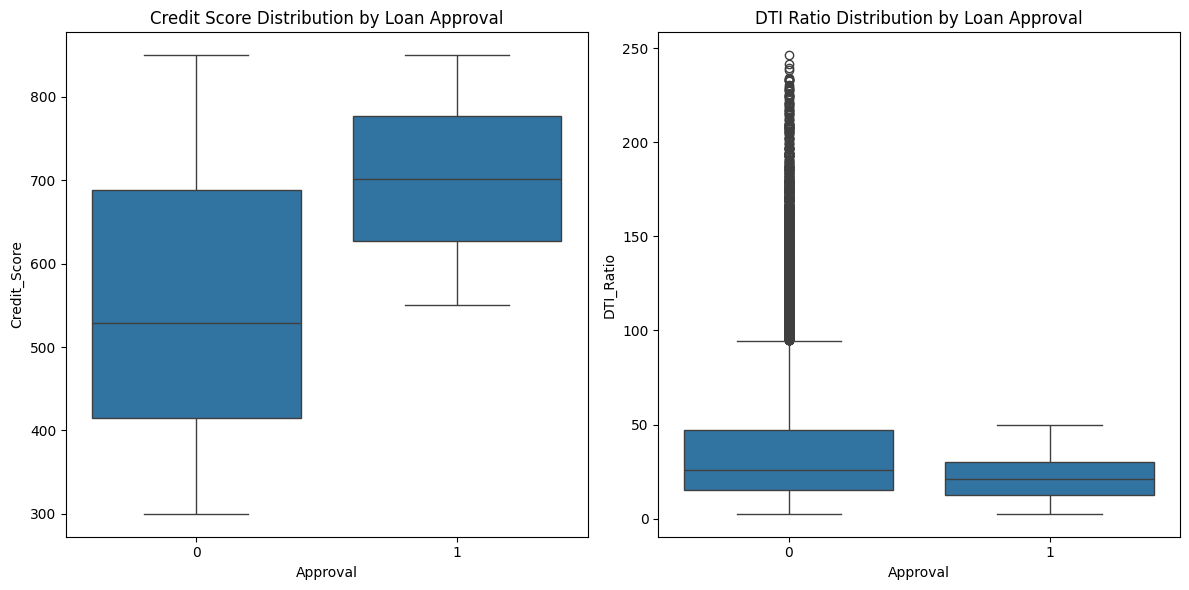

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Approval' column to a numeric binary value for easier plotting
df['Approval_Binary'] = df['Approval'].apply(lambda x: 1 if x == 'Approved' else 0)

# Set up the figure for subplots
plt.figure(figsize=(12, 6))

# Plot Credit Score vs Approval
plt.subplot(1, 2, 1)
sns.boxplot(x='Approval', y='Credit_Score', data=df)
plt.title('Credit Score Distribution by Loan Approval')

# Plot DTI Ratio vs Approval
plt.subplot(1, 2, 2)
sns.boxplot(x='Approval', y='DTI_Ratio', data=df)
plt.title('DTI Ratio Distribution by Loan Approval')

# Show the plots
plt.tight_layout()
plt.show()


- The majority of customers, the loan are being rejected!

> ### Drop the column that not gonna be used

In [4]:
# Remove 'customerID' as it is not informative for modeling
df.drop(columns=['Text'], inplace=True)

In [5]:
df.head()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
0,26556,581,8314,79.26,employed,Rejected
1,197392,389,111604,22.14,employed,Rejected
2,44561,523,34118,45.44,employed,Rejected
3,190363,729,118757,10.22,unemployed,Rejected
4,61853,732,19210,44.13,employed,Approved


In [6]:
df.tail()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
23995,195242,817,16403,24.32,employed,Approved
23996,150246,729,101572,9.97,employed,Rejected
23997,64571,650,30533,57.35,employed,Rejected
23998,115825,418,89837,10.37,unemployed,Rejected
23999,180440,769,15259,15.06,employed,Approved


> ### Check Duplicated Data

In [7]:
len(df.drop_duplicates()) / len(df)

1.0

- The dataset are safe from duplicated data!

> ### Check Missing Values

In [8]:
print(df.isnull().sum())

Income               0
Credit_Score         0
Loan_Amount          0
DTI_Ratio            0
Employment_Status    0
Approval             0
dtype: int64


- The dataset are safe from missing value!

> ### Categorical Columns

In [9]:
categorical_columns = [
    'Employment_Status', 'Approval'
]

> ### Numerical Columns

In [10]:
# Define numerical columns
numerical_columns = ['Income','Credit_Score','Loan_Amount','DTI_Ratio']
			

> ### Target Distribution

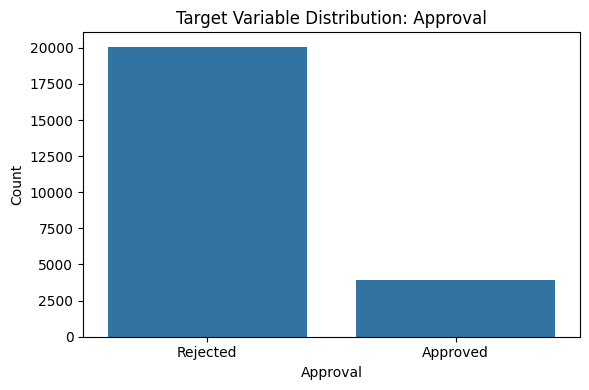

In [11]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Approval', data=df)
plt.title('Target Variable Distribution: Approval')
plt.xlabel('Approval')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

- Conclusion
    - The bar chart shows the class distribution of the target variable (likely "Loan Approval" or similar).
    - There are two classes: "Rejected" and "Approved" .
    - The "Rejected" class is significantly more frequent than the "Approved" class.
    - This indicates a clear class imbalance , which may affect model performance if not handled properl

In [12]:
df.head()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
0,26556,581,8314,79.26,employed,Rejected
1,197392,389,111604,22.14,employed,Rejected
2,44561,523,34118,45.44,employed,Rejected
3,190363,729,118757,10.22,unemployed,Rejected
4,61853,732,19210,44.13,employed,Approved


> ### Data Manipulation, Feature Engineering
- Encode the dataset with Label Encoder

The reason why we using LabelEncoder because it is the best choice for binary and ordinal categorical variables in your dataset, as it preserves the relationship between categories and is computationally efficient.

In [13]:
df['Approval'] = df['Approval'].apply(lambda x: 1 if x == 'Approved' else 0)
df['Employment_Status'] = df['Employment_Status'].apply(lambda x: 1 if x == 'employed' else 0)

In [14]:
df.head()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
0,26556,581,8314,79.26,1,0
1,197392,389,111604,22.14,1,0
2,44561,523,34118,45.44,1,0
3,190363,729,118757,10.22,0,0
4,61853,732,19210,44.13,1,1


In [15]:
df.to_csv("X_train.csv")

---
> ### Split the dataset

In [16]:
# split train test
from sklearn.model_selection import train_test_split

feature = df.drop(columns='Approval')
target = df[['Approval']]

# First splitting: pretrain and test
feature_dataset_pretrain, feature_dataset_test, target_dataset_pretrain, target_dataset_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_dataset_train, feature_dataset_validation, target_dataset_train, target_dataset_validation = train_test_split(feature_dataset_pretrain, target_dataset_pretrain, test_size=0.20, random_state=42)

> #### Check the outlier

In [17]:
import scipy.stats as stats

def check_plot(x_train, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))


    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=x_train[variable])
    plt.title('Boxplot')

    plt.show()

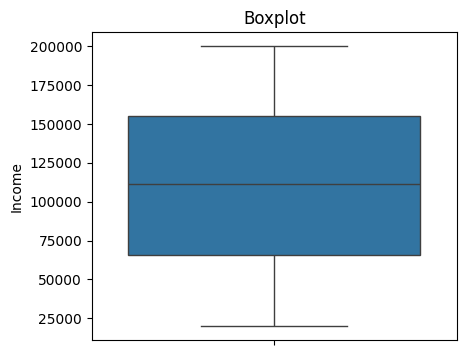

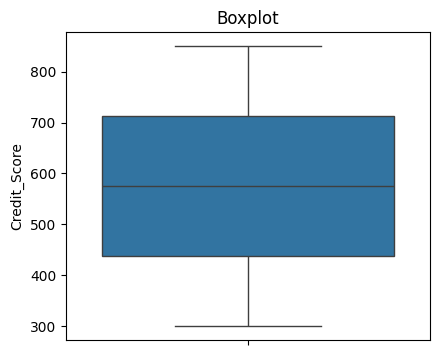

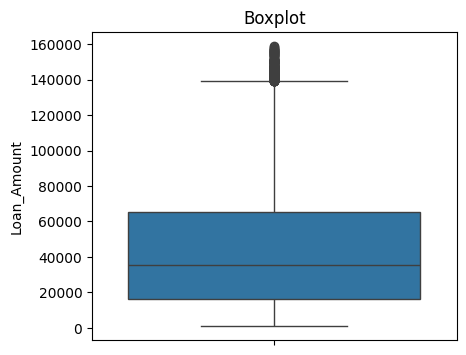

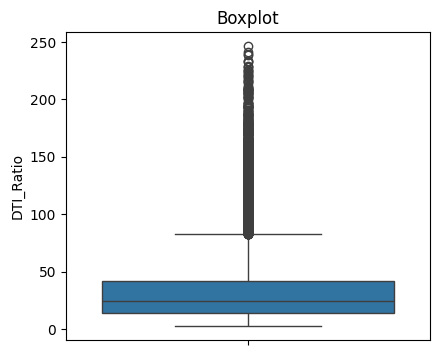

In [18]:
numeric_columns = feature_dataset_train.select_dtypes(include=['number']).columns
for col in numeric_columns:
    if col in ['Income','Credit_Score','Loan_Amount','DTI_Ratio']:
        check_plot(feature_dataset_train, col)

- There is outliers on loan_amount and DTI_ratio

In [19]:
import numpy as np

# Handle outliers for Loan Amount using IQR (Interquartile Range)
Q1_loan = feature_dataset_train['Loan_Amount'].quantile(0.25)
Q3_loan = feature_dataset_train['Loan_Amount'].quantile(0.75)
IQR_loan = Q3_loan - Q1_loan
lower_bound_loan = Q1_loan - 1.5 * IQR_loan
upper_bound_loan = Q3_loan + 1.5 * IQR_loan

# Cap outliers in the Loan Amount feature
feature_dataset_train['Loan_Amount'] = np.where(feature_dataset_train['Loan_Amount'] < lower_bound_loan, lower_bound_loan,
                                   np.where(feature_dataset_train['Loan_Amount'] > upper_bound_loan, upper_bound_loan, feature_dataset_train['Loan_Amount']))

# Repeat the same for the test set
feature_dataset_test['Loan_Amount'] = np.where(feature_dataset_test['Loan_Amount'] < lower_bound_loan, lower_bound_loan,
                                  np.where(feature_dataset_test['Loan_Amount'] > upper_bound_loan, upper_bound_loan, feature_dataset_test['Loan_Amount']))

# Handle outliers for DTI Ratio using IQR (Interquartile Range)
Q1_dti = feature_dataset_train['DTI_Ratio'].quantile(0.25)
Q3_dti = feature_dataset_train['DTI_Ratio'].quantile(0.75)
IQR_dti = Q3_dti - Q1_dti
lower_bound_dti = Q1_dti - 1.5 * IQR_dti
upper_bound_dti = Q3_dti + 1.5 * IQR_dti

# Cap outliers in the DTI Ratio feature
feature_dataset_train['DTI_Ratio'] = np.where(feature_dataset_train['DTI_Ratio'] < lower_bound_dti, lower_bound_dti,
                                 np.where(feature_dataset_train['DTI_Ratio'] > upper_bound_dti, upper_bound_dti, feature_dataset_train['DTI_Ratio']))

# Repeat the same for the test set
feature_dataset_test['DTI_Ratio'] = np.where(feature_dataset_test['DTI_Ratio'] < lower_bound_dti, lower_bound_dti,
                                np.where(feature_dataset_test['DTI_Ratio'] > upper_bound_dti, upper_bound_dti, feature_dataset_test['DTI_Ratio']))

# Check the values after capping outliers for Loan Amount and DTI Ratio
print(f"Loan Amount column in training set: Min = {feature_dataset_train['Loan_Amount'].min()}, Max = {feature_dataset_train['Loan_Amount'].max()}")
print(f"Loan Amount column in test set: Min = {feature_dataset_test['Loan_Amount'].min()}, Max = {feature_dataset_test['Loan_Amount'].max()}")
print(f"DTI Ratio column in training set: Min = {feature_dataset_train['DTI_Ratio'].min()}, Max = {feature_dataset_train['DTI_Ratio'].max()}")
print(f"DTI Ratio column in test set: Min = {feature_dataset_test['DTI_Ratio'].min()}, Max = {feature_dataset_test['DTI_Ratio'].max()}")


Loan Amount column in training set: Min = 1005.0, Max = 138968.625
Loan Amount column in test set: Min = 1010.0, Max = 138968.625
DTI Ratio column in training set: Min = 2.53, Max = 82.84875
DTI Ratio column in test set: Min = 2.62, Max = 82.84875


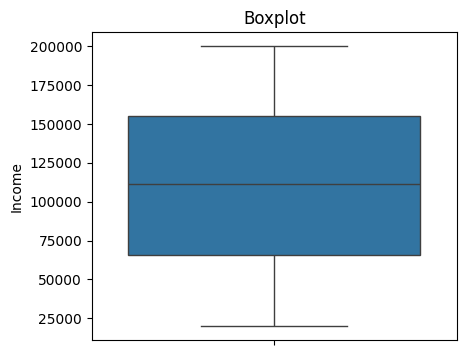

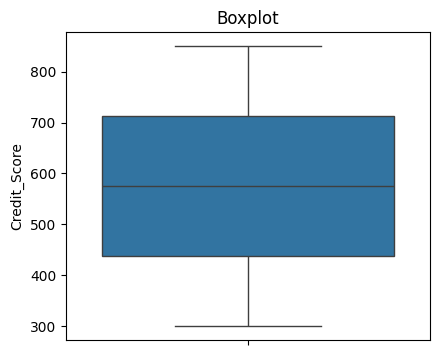

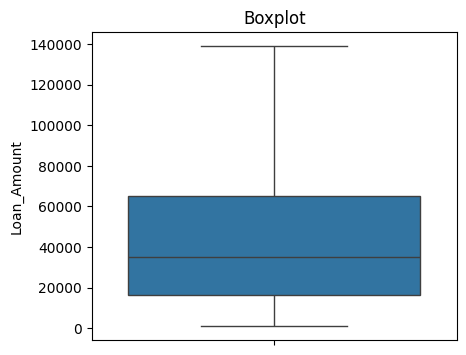

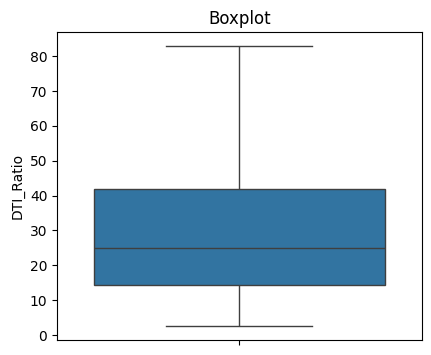

In [20]:
numeric_columns = feature_dataset_train.select_dtypes(include=['number']).columns
for col in numeric_columns:
    if col in ['Income','Credit_Score','Loan_Amount','DTI_Ratio']:
        check_plot(feature_dataset_train, col)

- The dataset are safe from Outliers

> ### Scaling

In [21]:
feature_dataset_test.head()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status
3111,88429,559,66289.0,48.46000,1
18679,109533,420,82072.0,22.94000,1
17472,77025,365,6527.0,7.73000,1
21451,87875,396,41918.0,17.35000,0
20800,38908,502,13872.0,82.84875,1


In [22]:
feature_dataset_train.head()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status
5670,80724,662,22371.0,41.35000,0
16258,26373,477,10227.0,82.84875,1
3162,58831,331,23460.0,20.55000,1
17194,35428,639,13692.0,79.01000,0
5874,41154,330,11866.0,32.50000,1


In [23]:
# min-max scaler based on training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

minmax_scaler = scaler.fit(feature_dataset_train)
X_train_scaled = minmax_scaler.transform(feature_dataset_train)
X_test_scaled = minmax_scaler.transform(feature_dataset_test)

In [24]:
df['Approval'].value_counts()

Approval
0    20067
1     3933
Name: count, dtype: int64

> The class distribution is IMBALANCE, so need NOT to use `accuracy`. Use `recall` (sensitivity)

> ### Model Training and Evaluation

--------
- #### Hyperparameters
    - We will **scale** the features using **StandardScaler** to normalize the data, which is important for distance-based models like KNN.
    - We train KNN model because the loan dataset contains several numeric features that can be compared using distance metrics, such as:
        - **Income**
        - **Credit_Score**
        - **Loan_Amount**
        - **DTI_Ratio** (Debt-to-Income Ratio)

KNN uses distance metrics (such as Euclidean Distance) to measure how similar two borrowers are this fits well with the structure of this dataset.


> ### KNN

In [25]:
# define the estimator/model
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [26]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_neighbors': (2,3,4,5,6,7,8)
}

knn_clf_gridcv = GridSearchCV(knn_clf, parameters, cv=5, scoring='recall')
knn_clf_gridcv.fit(X_train_scaled, target_dataset_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8)},
             scoring='recall')

In [27]:
# the compact results
cv_result = pd.DataFrame(knn_clf_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols]

,params,mean_test_score,rank_test_score
0,{'n_neighbors': 2},0.892056,7
1,{'n_neighbors': 3},0.949789,2
2,{'n_neighbors': 4},0.914198,6
3,{'n_neighbors': 5},0.948205,3
4,{'n_neighbors': 6},0.929620,5
5,{'n_neighbors': 7},0.952554,1
6,{'n_neighbors': 8},0.933577,4


- The best n_neighbors is 7

> #### Evaluation metrics on test data

- Before Tuning

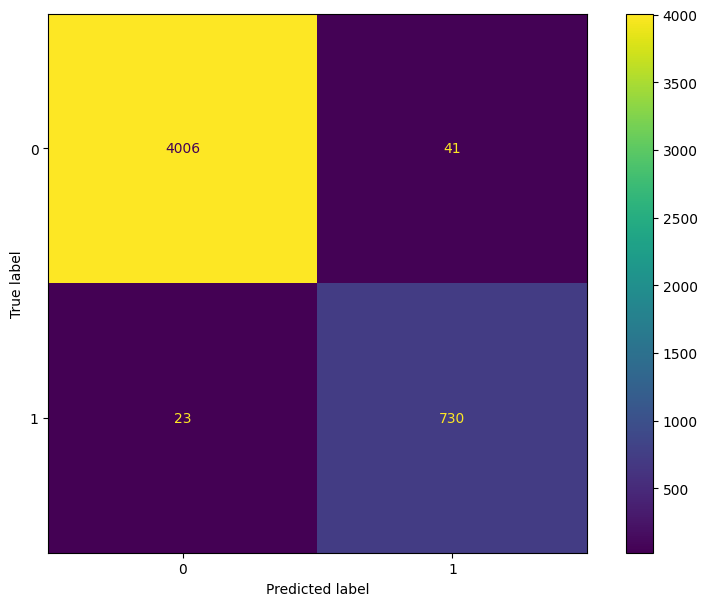

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

# Train the default KNN model (Before tuning)
knn_clf_default = KNeighborsClassifier(n_neighbors=7)  # Default n_neighbors=5
knn_clf_default.fit(X_train_scaled, target_dataset_train.values.ravel())

# Make predictions using the default model
y_pred_default = knn_clf_default.predict(X_test_scaled)

# Plot confusion matrix for the default model
fig, ax = plt.subplots(figsize=(10, 7))
cm_default = confusion_matrix(target_dataset_test, y_pred_default, labels=knn_clf_default.classes_)

# Display the confusion matrix
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default,
                                      display_labels=knn_clf_default.classes_)
disp_default.plot(ax=ax)
plt.show()


- After Tuning

In [29]:
feature_dataset_train.head()

,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status
5670,80724,662,22371.0,41.35000,0
16258,26373,477,10227.0,82.84875,1
3162,58831,331,23460.0,20.55000,1
17194,35428,639,13692.0,79.01000,0
5874,41154,330,11866.0,32.50000,1


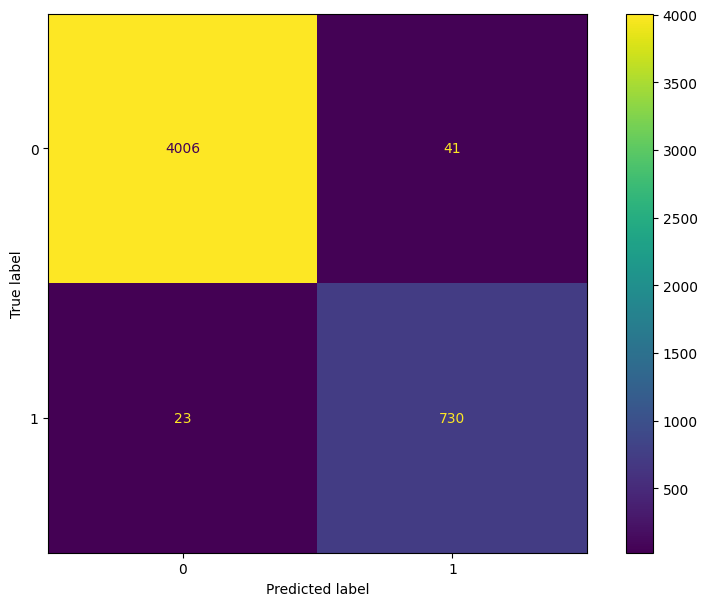

In [30]:
fig, ax = plt.subplots(figsize=(10,7))
y_pred = knn_clf_gridcv.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(target_dataset_test, y_pred, labels=knn_clf_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=knn_clf_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

> ### Explanation of Confusion Matrices (Before and After Hyperparameter Tuning for KNN)

- #### **Before Hyperparameter Tuning:**

    - **True negatives (4006):** The model correctly predicted label 0 (negative instances).
    - **False positives (41):** The model incorrectly predicted label 1 when the true label was 0.
    - **False negatives (23):** The model incorrectly predicted label 0 when the true label was 1.
    - **True positives (730):** The model correctly predicted label 1 (positive instances).

- #### **After Hyperparameter Tuning:**

    - **True negatives (4006):** The model performed similarly in correctly predicting label 0 (negative class).
    - **False positives (41):** There was no change in the number of false positives.
    - **False negatives (23):** The number of false negatives remained the same.
    - **True positives (730):** The true positives remained unchanged as well.

#### **Summary:**
- **No significant change:** There was no improvement or degradation in model performance after hyperparameter tuning. Both the true positives, true negatives, false positives, and false negatives remained the same across the before and after models.

----


In [31]:
# Default KNN model (Before Tuning)
knn_clf_default = KNeighborsClassifier(n_neighbors=5)  # Default n_neighbors=5
knn_clf_default.fit(X_train_scaled, target_dataset_train.values.ravel())

# Predict and evaluate (Before Tuning)
y_pred_default = knn_clf_default.predict(X_test_scaled)
print("Classification Report (Before Tuning):")
print(classification_report(target_dataset_test, y_pred_default))

# Predicted probabilities for ROC AUC
y_prob_default = knn_clf_default.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC AUC for the default model
roc_auc_default = roc_auc_score(target_dataset_test, y_prob_default)
print(f"ROC AUC (Before Tuning): {roc_auc_default}")


Classification Report (Before Tuning):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4047
           1       0.95      0.97      0.96       753

    accuracy                           0.99      4800
   macro avg       0.97      0.98      0.98      4800
weighted avg       0.99      0.99      0.99      4800

ROC AUC (Before Tuning): 0.9961424379083617


In [32]:
# Predict labels
y_pred = knn_clf_gridcv.best_estimator_.predict(X_test_scaled)
print("Classification Report (After Tuning):")
# Print classification report
print(classification_report(target_dataset_test, y_pred))

# Get predicted probabilities
y_prob = knn_clf_gridcv.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Calculate and print ROC AUC
roc_auc = roc_auc_score(target_dataset_test, y_prob)
print(f"ROC AUC (After Tuning): {roc_auc}")


Classification Report (After Tuning):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4047
           1       0.95      0.97      0.96       753

    accuracy                           0.99      4800
   macro avg       0.97      0.98      0.98      4800
weighted avg       0.99      0.99      0.99      4800

ROC AUC (After Tuning): 0.9962289053160556


### Explanation Based on the Classification Report and ROC AUC:

- #### **Before and After Hyperparameter Tuning:**

1. **Precision** for **Rejected (class 0)** is **99%**, and **recall** is **99%** in both cases, indicating the model performs excellently in identifying rejected instances with high precision and recall.
2. **Precision** for **Approved (class 1)** is **95%** for precision and **97%** for recall before tuning, and **95%** precision and **97%** recall after tuning, showing consistent performance in predicting approved instances.
3. **Accuracy** remains **99%** in both models, meaning the model is correct 99% of the time across both classes.
4. **Macro Average** precision, recall, and F1-score are **97%**, **98%**, and **98%** respectively, both before and after tuning, showing strong, balanced performance across both classes.
5. **Weighted Average** precision, recall, and F1-score are **99%**, **99%**, and **99%** respectively, showing excellent performance when considering class distribution.
6. **ROC AUC** after tuning is **0.9962**, which is an exceptionally high value, indicating the model's ability to distinguish between approved and rejected instances with almost perfect separation.

---

### Key Observations:

- **For Rejected (class 0)**: The model performs very well with **high precision** and **high recall**, meaning it can accurately predict rejected instances while minimizing false positives and false negatives.
- **For Approved (class 1)**: The model maintains a solid performance with **95% precision** and **97% recall**, demonstrating reliable accuracy in predicting approved instances.
- **ROC AUC** is very high at **0.996**, signifying near-perfect ability to distinguish between approved and rejected instances.

---

### Conclusion:

- **No significant change**: After hyperparameter tuning, the model's performance in terms of precision, recall, F1-score, accuracy, and ROC AUC did not change significantly. It maintained the same high performance.
- The **ROC AUC of 0.996** confirms that the model still has an **outstanding ability** to separate the two classes (Approved and Rejected).
- **Hyperparameter tuning** did not result in a substantial improvement or degradation, indicating that the model was already performing optimally. The model remains highly accurate and reliable for predicting approval decisions.

---

### Use the Hyperparameter-Tuned Model!

- The hyperparameter-tuned model can be used because the `ROC-AUC` is slightly better than before tuning. The performance is already very strong, with consistent results across both before and after tuning, and the model demonstrates a **high ability** to distinguish between approved and rejected instances. Thus, the model is already optimized for accurate predictions.


Average Credit Score based on Approval:
Approval
0    550.875224
1    701.565045
Name: Credit_Score, dtype: float64

Average DTI Ratio based on Approval:
Approval
0    33.372795
1    21.951578
Name: DTI_Ratio, dtype: float64


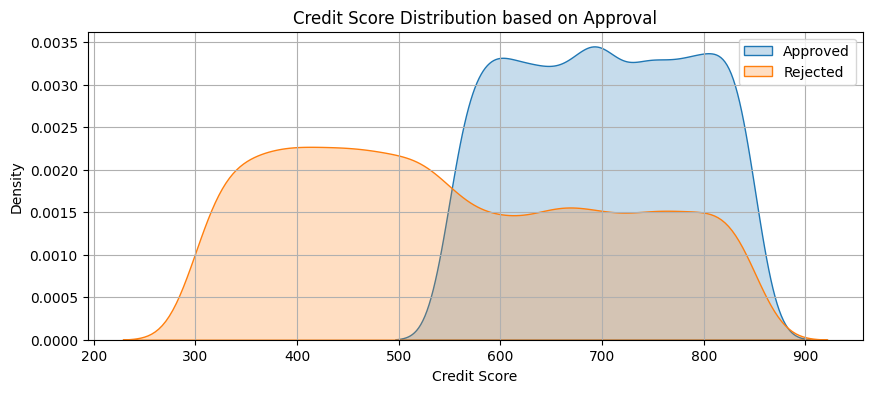

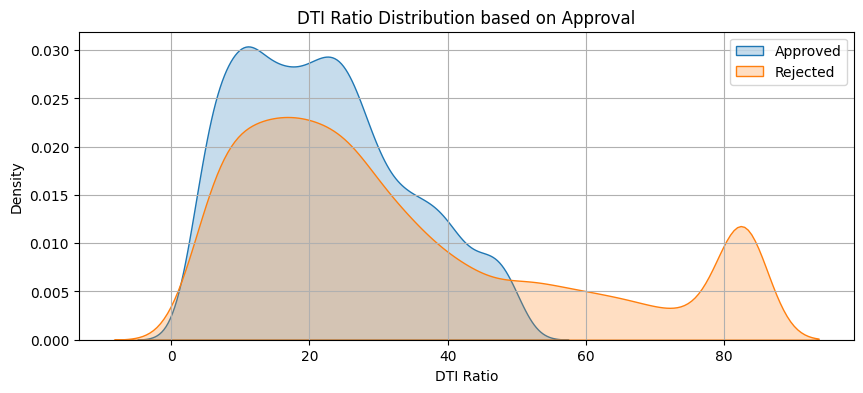

In [53]:
# Recombine features and targets for analysis
train_data = feature_dataset_train.copy()
train_data['Approval'] = target_dataset_train.values

# Display average Credit Score and DTI Ratio based on Approval
print("Average Credit Score based on Approval:")
print(train_data.groupby('Approval')['Credit_Score'].mean())

print("\nAverage DTI Ratio based on Approval:")
print(train_data.groupby('Approval')['DTI_Ratio'].mean())

# --- Credit Score Visualization ---
plt.figure(figsize=(10, 4))
sns.kdeplot(train_data[train_data['Approval'] == 1]['Credit_Score'], label='Approved', shade=True)
sns.kdeplot(train_data[train_data['Approval'] == 0]['Credit_Score'], label='Rejected', shade=True)
plt.title('Credit Score Distribution based on Approval')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# --- DTI Ratio Visualization ---
plt.figure(figsize=(10, 4))
sns.kdeplot(train_data[train_data['Approval'] == 1]['DTI_Ratio'], label='Approved', shade=True)
sns.kdeplot(train_data[train_data['Approval'] == 0]['DTI_Ratio'], label='Rejected', shade=True)
plt.title('DTI Ratio Distribution based on Approval')
plt.xlabel('DTI Ratio')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

---
### 1. Credit Score

- **Curve for Approved (blue)**: Centered around high credit scores (around 700–800).
- **Curve for Rejected (orange)**: Centered around low credit scores (around 400–600).

**Concordance**:
- **Average Credit Score of Approved**: 701.565045
- The Approved curve is indeed centered around this value.
- **Average Credit Score of Rejected**: 550.875224
- The Rejected curve also matches this average.

**Conclusion**:
- The Credit Score visualization closely matches the statistics provided. The distribution of the KDE curves reflects that borrowers with higher credit scores are more likely to get loan approvals.

---

### 2. DTI Ratio

- **Curve for Approved (blue)**: Centered around low DTI Ratios (around 0–20).
- **Curve for Rejected (orange)**: Centered around higher DTI Ratios (around 0–50), but with a long tail to very high values ​​(e.g. >80).

**Concordance**:
- **Approved Average DTI Ratio**: 21.951578
- The Approved curve is indeed centered around this value.
- **Rejected Average DTI Ratio**: 33.372795
- The Rejected curve also fits this average, although there are outliers at very high DTI Ratio values.

> ### Model Deployment

In [33]:
import joblib

# Assuming the tuned model is stored in 'knn_clf_gridcv.best_estimator_'
joblib.dump(knn_clf_gridcv.best_estimator_, 'knn_model.pkl')


['knn_model.pkl']

In [34]:
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']